In [8]:
import pandas as pd
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import shap
import pickle
from sklearn.cluster import AgglomerativeClustering,DBSCAN
from networkx.algorithms import community
import sklearn_tda as sktda
# Can be downloaded at https://github.com/MathieuCarriere/sklearn-tda
import statmapper as stm
# Can be downloaded at https://github.com/MathieuCarriere/statmapper
from metricmapper import *
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [9]:
directory = 'demo_data/diabetes/{}.csv'
X_combine = np.genfromtxt(directory.format('X_combine'),delimiter=',')
pred_combine = np.genfromtxt(directory.format('pred_combine'),delimiter=',')

X = pd.read_csv(directory.format('X'))
columns = X.columns
X = X.to_numpy()

X_sample = X_combine[X.shape[0]:,:]
pred_sample = pred_combine[X.shape[0]:]

pred = pred_combine[:X.shape[0]]

similarity = np.genfromtxt('demo_data/diabetes/similarity.csv',delimiter=',') 

## Graph Similarity with Vertex Edge Overlap (VEO)

In [10]:
from scipy.spatial.distance import cdist
from collections import Counter

def graph_sim(g1,g2,verbose=0):
    n1 = list(g1['nodes'].keys())
    n2 = list(g2['nodes'].keys())
    
    #Acquire node correspondence and similarity
    n_nodes = max(np.max([np.max(g1['nodes'][n]) for n in n1]),np.max([np.max(g2['nodes'][n]) for n in n2])) + 1
    
    n1_vec = np.zeros((len(n1),n_nodes))
    for i,n in enumerate(n1):
        n1_vec[i,g1['nodes'][n]] = 1

    
    n2_vec = np.zeros((len(n2),n_nodes))
    for i,n in enumerate(n2):
        n2_vec[i,g2['nodes'][n]] = 1
        
    dist = 1 - cdist(n1_vec,n2_vec,'jaccard')
    n1_correspondence = np.argmax(dist,1)
    n2_correspondence = np.argmax(dist,0)

    if verbose == 1:
        print(np.max(dist,1),np.max(dist,0))
    node_intersection = np.sum(np.max(dist,1)) + np.sum(np.max(dist,0))

    #edge similarity
    n1_hash = {n:i for i,n in enumerate(n1)}
    n2_hash = {n:i for i,n in enumerate(n2)}
    edges = {}
    edge_intersection = 0
    edges_total = 0

    for _n1 in g1['links']:
        for _n2 in g1['links'][_n1]:
            edges[(n1_hash[_n1],n1_hash[_n2])] = 1
            edges_total += 1

    for _n1 in g2['links']:
        for _n2 in g2['links'][_n1]:
            edges_total += 1
            _nc1 = n2_correspondence[n2_hash[_n1]]
            _nc2 = n2_correspondence[n2_hash[_n2]]
            _nc1, _nc2 = np.sort([_nc1, _nc2])
            if (_nc1,_nc2) in edges:
                edge_intersection += 1
                del edges[(_nc1,_nc2)]
                
    graph_similarity = (node_intersection + edge_intersection * 2) / (dist.shape[0] + dist.shape[1] + edges_total)
    return graph_similarity

## Visualize Diabetes Dataset Explanations (Opacity: Similarity with Other Graphs)

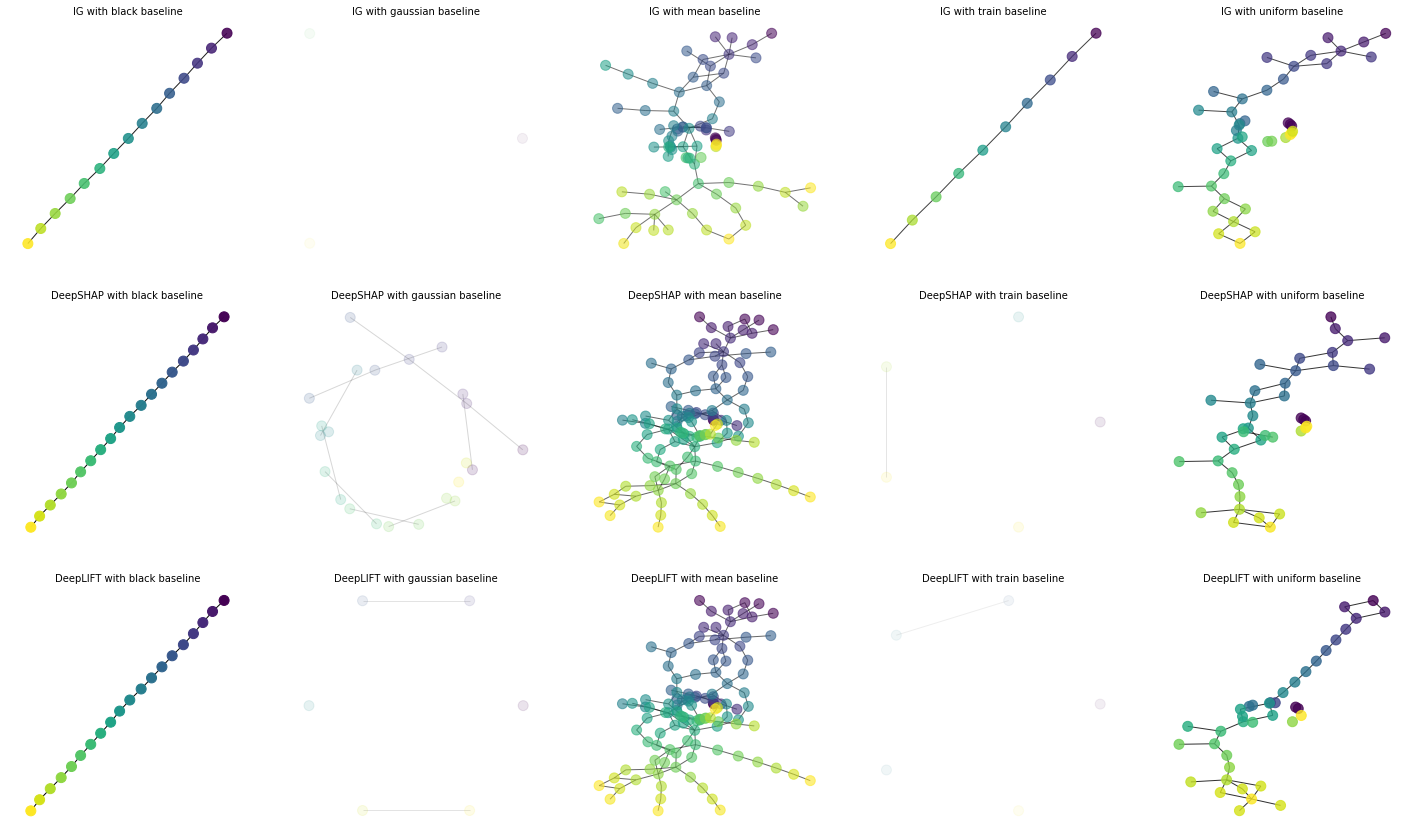

In [11]:
methods = ['IG','DeepSHAP','DeepLIFT']
baselines = ['black','gaussian','mean','train','uniform']
n_rows = 4
n_cols = 5
opacity = np.mean(similarity,1)
opacity /= np.max(opacity) # mean of pairwise similarity as consensus

plt.figure(figsize=(5*n_cols,5*n_rows))

i = 0
j = 1
k=0
graphs = {}
for method in methods:
    for baseline in baselines:
        with open('demo_data/diabetes/config_{}_{}.obj'.format(method,baseline), 'rb') as fp:
            r,g,distance = pickle.load(fp)
            exp_combine = np.genfromtxt(directory.format('{}_{}'.format(method,baseline)),delimiter=',')
            exp_combine = scaler.fit_transform(exp_combine)

            exp_sample = exp_combine[X.shape[0]:,:]
            exp = exp_combine[:X.shape[0],:]
            
            cover = HypercubeCover(cover_mode="implicit", 
                                           bnds=np.array([[-1.,1]]), 
                                           resolutions=np.array([r]), 
                                           gains=np.array([g]))
            params = {'filters':pred_combine.reshape(-1,1),'colors':pred_combine.reshape(-1,1),'codomain':'vectors','cover':cover,'clustering':DBSCAN(eps=distance)}
            M = MetricMapperComplex(**params).fit(exp_combine)
            G = stm.mapper2networkx(M)
            plt.subplot(n_rows,n_cols,i*n_cols+j)
            plt.title("{} with {} baseline".format(method,baseline), fontdict = {'fontsize' : 10})
            nx.draw(G, pos=nx.kamada_kawai_layout(G), 
                node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()],node_size=100,alpha=opacity[k])
            graphs["{} with {} baseline".format(method,baseline)] = M
            k+=1
        j += 1 
        if j > n_cols:
            i += 1
            j = 1

## Inspect Individual Explanation

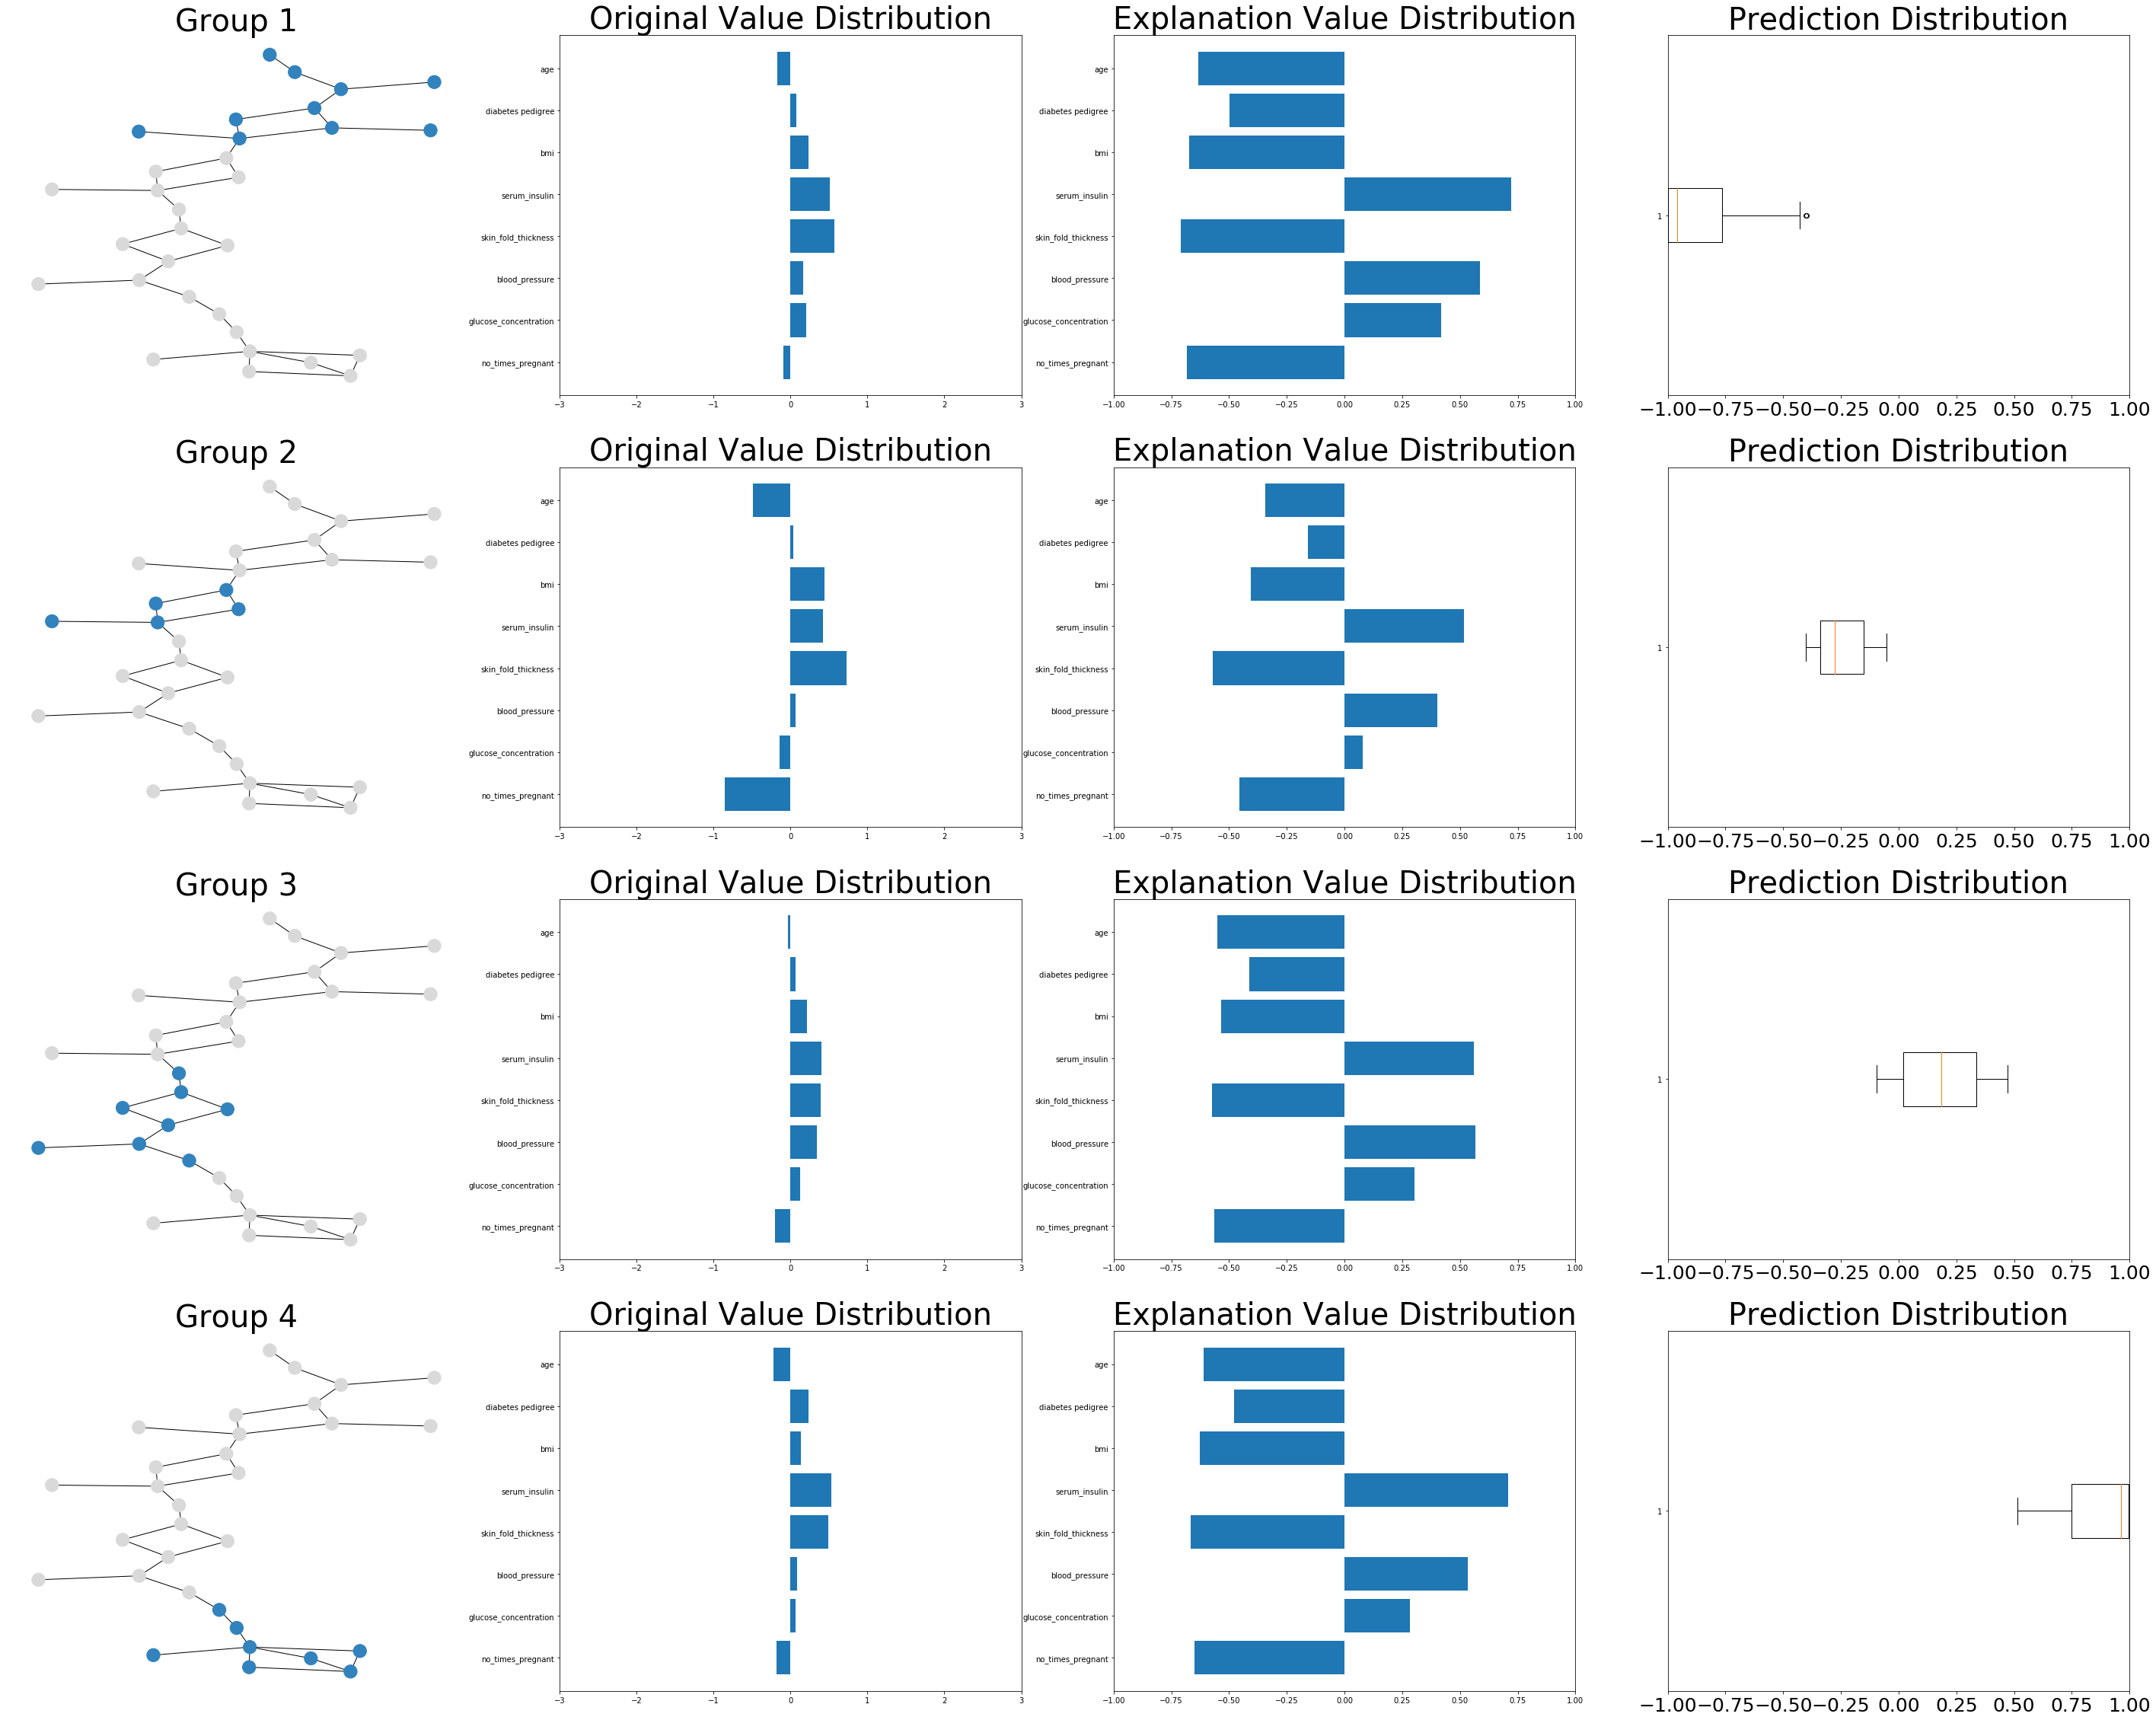

In [31]:
M = graphs['DeepSHAP with uniform baseline'] ## select one explanation to examine

G = stm.mapper2networkx(M)

largest_cc = max(nx.connected_components(G), key=len)

G =G.subgraph(largest_cc)

from networkx.algorithms import community
communities_generator = community.girvan_newman(G)
n_hierarchy = 3
for n in range(n_hierarchy):
    try:
        next_level_communities = next(communities_generator)
    except:
        pass
comm = sorted(map(sorted, next_level_communities))

n_plots = 4
stuff_org = comm
stuff = []
order_by_pred = []
for bd in stuff_org:
    pts = set()
    if type(bd) == list:
        for b in bd:
            pts.update(M.node_info_[b]['indices'])
    else:
        pts.update(M.node_info_[bd]['indices'])
    pts=np.array(list(pts))
    pts = pts[pts<X.shape[0]]
    if len(pts) > 10:
        stuff.append(bd)
        order_by_pred.append(np.mean(pred[pts]))
idx = np.argsort(order_by_pred)
stuff = np.array(stuff,dtype=object)[idx].tolist()

plt.figure(figsize=(50,10*len(stuff)))
for idx, bd in enumerate(stuff):
    plt.subplot(len(stuff),n_plots,idx*n_plots+1)
    plt.title("Group {}".format(idx+1), fontdict = {'fontsize' : 40})
    if type(bd) == list:
        cond = [0 if node in bd else 1 for node in G.nodes()]
    else:
        cond = [0 if node == bd else 1 for node in G.nodes()]
    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
            node_color=cond,cmap='tab20c')
    plt.subplot(len(stuff),n_plots,idx*n_plots+2)
    pts = set()
    if type(bd) == list:
        for b in bd:
            pts.update(M.node_info_[b]['indices'])
    else:
        pts.update(M.node_info_[bd]['indices'])
    pts=np.array(list(pts))
    pts = pts[pts<X.shape[0]]
    c = np.zeros(X.shape[0])
    c[pts] = 1
    c = c.astype(bool)
    
    plt.title("Original Value Distribution", fontdict = {'fontsize' : 40})
    selected_X = scaler.fit_transform(X)[pts,:]
    plt.barh(columns,selected_X.mean(0))
    plt.xlim(-3,3)
    
    plt.subplot(len(stuff),n_plots,idx*n_plots+3)
    plt.title("Explanation Value Distribution", fontdict = {'fontsize' : 40})
    selected_exp = scaler.fit_transform(exp)[pts,:]
    plt.barh(columns,selected_exp.mean(0))
    plt.xlim(-1,1)
#     plt.ylim(-5,5)
    
    plt.subplot(len(stuff),n_plots,idx*n_plots+4)
    plt.boxplot(pred.flatten()[pts],vert=False)
    plt.xlim((-1,1))
    plt.xticks(fontsize=25)
    plt.title("Prediction Distribution", fontdict = {'fontsize' : 40})
plt.show()